In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [2]:
data_import = pd.read_csv('../Data/LT_DU_data_for_ML_All_variations_optimized_outliers.csv',
usecols=['hourly_rate', 'esize_class_ord', 'gender_M', 'age_class_ord', 'education_ord', 'lpk', 'experience_sc']) # All variations of categorical and numeric transformations
data_import.columns

Index(['lpk', 'hourly_rate', 'esize_class_ord', 'gender_M', 'age_class_ord',
       'education_ord', 'experience_sc'],
      dtype='object')

# Test with XGBoost (not optimized)

In [3]:
def observations_below_threshold(df, upper_threshold=0.95):
    """Select observations, which exceed  hourly rate 
     threshold for lpk groups. Threshold is defined by quantile"""
    df['rank'] = df.groupby('lpk')['hourly_rate'].rank(pct=True).copy()
    df = df.query('rank < @upper_threshold')
    df = df.drop(columns='rank')     
    return df

In [4]:
def observations_between_thresholds(df, lower_threshold=0.05, upper_threshold=0.95):
    """Select observations, with hourly rate between
     thresholds for lpk groups. Thresholds are defined by quantile"""
    df['rank'] = df.groupby('lpk')['hourly_rate'].rank(pct=True).copy()
    df = df.query('rank < @upper_threshold & rank > @lower_threshold')
    df = df.drop(columns='rank')     
    return df

In [5]:
upper_threshold = 0.80
lower_threshold = 0.20

Dataset lengths: train 17456 , test 4365
Train: RMSE= 0.919  R2= 0.818
Test: RMSE= 1.185  R2= 0.704


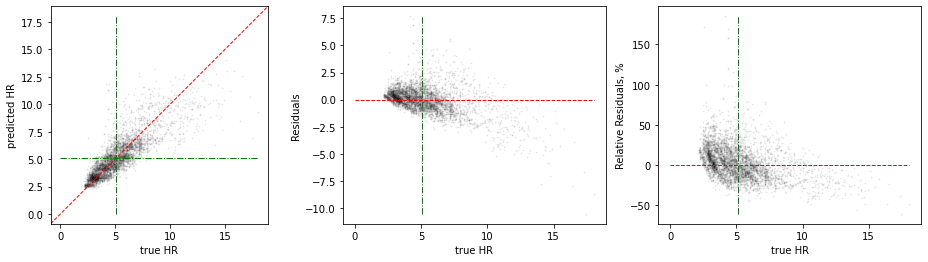

In [6]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

data = data_import.copy()

df = observations_between_thresholds(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
y = df['hourly_rate']
X = df.drop(columns='hourly_rate')

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)

print('Dataset lengths:',
    'train', len(y_train),
    ', test', len(y_test))

model = XGBRegressor()
model.fit(X=X_train, y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
residuals_test=y_test_pred-y_test
r_residuals_test=(y_test_pred-y_test)/y_test*100

print('Train: RMSE=', np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3),
    ' R2=', r2_score(y_train, y_train_pred).round(3))

print('Test: RMSE=', np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3),
    ' R2=', r2_score(y_test, y_test_pred).round(3))

y_train_mean = np.mean(y_train)

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
sns.scatterplot(ax=ax[0], x=y_test, y=y_test_pred,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[0],  x=y_test, y=y_test_pred, alpha=0.5 )
ax[0].set_xlabel('true HR')
ax[0].set_ylabel('predicted HR')
ax[0].set_aspect(aspect=1, adjustable=None, anchor=None, share=False)
ax[0].plot((0,1), (0, 1), transform=ax[0].transAxes, linestyle='--', color='r', lw=1)
ax[0].vlines(ymin=0, ymax=max(y_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[0].hlines(xmin=0, xmax=max(y_test) , y=y_train_mean, linestyle='-.', color='g', lw=1)

sns.scatterplot(ax=ax[1],  x=y_test, y=residuals_test,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[1], x=y_test, y=residuals_test, alpha=0.5 )
ax[1].set_xlabel('true HR')
ax[1].set_ylabel('Residuals')
ax[1].vlines(ymin=min(residuals_test), ymax=max(residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[1].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1)

sns.scatterplot(ax=ax[2],  x=y_test, y=r_residuals_test,  s=3, color='black', alpha=0.1)
#sns.kdeplot(ax=ax[2],  x=y_test, y=r_residuals_test, alpha=0.5 )
ax[2].set_xlabel('true HR')
ax[2].set_ylabel('Relative Residuals, %')
ax[2].vlines(ymin=min(r_residuals_test), ymax=max(r_residuals_test) , x=y_train_mean, linestyle='-.', color='g', lw=1)
ax[2].hlines(xmin=0, xmax=max(y_test) , y=0, linestyle='--', color='r', lw=1);

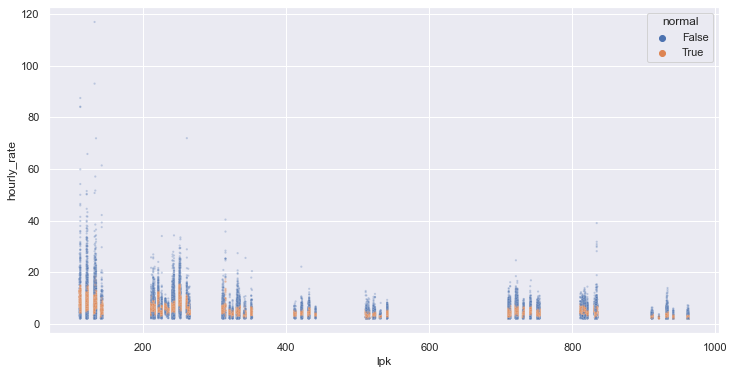

In [7]:
data = data_import.copy()
data['rank'] = data.groupby('lpk')['hourly_rate'].rank(pct=True)
data['normal'] = (data['rank']>lower_threshold) & (data['rank']<upper_threshold)
data['lpk_c'] = str(data['lpk'])

sns.set_theme(rc={"figure.figsize":(12, 6)})
sns.scatterplot(data=data, x='lpk', y='hourly_rate', hue='normal', alpha=0.3, s=5);

In [79]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

upper_threshold_list = []
lower_threshold_list = []
train_size = []
test_size = []
rmse_train_list = []
rmse_test_list = []
r2_train_list = []
r2_test_list = []

for upper_threshold in np.linspace(0.6, 1.0, 9).round(2):
    for lower_threshold in np.linspace(0.0, 0.3, 7).round(2):
        
        upper_threshold_list.append(upper_threshold)
        lower_threshold_list.append(lower_threshold)

        data = data_import.copy()
        df = observations_between_thresholds(data, lower_threshold=lower_threshold, upper_threshold=upper_threshold)
        y = df['hourly_rate']
        X = df.drop(columns='hourly_rate')
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
        
        train_size.append(len(y_train))
        test_size.append(len(y_test))

        model = XGBRegressor()
        model.fit(X=X_train, y=y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_train = r2_score(y_train, y_train_pred)


        rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred))
        r2_test = r2_score(y_train, y_train_pred)

        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)

size_effect = pd.DataFrame({'upper': upper_threshold_list,
                            'lower': lower_threshold_list,
                            'train_size': train_size,
                            'test_size': test_size,
                            'rmse_train': rmse_train_list,
                            'rmse_test': rmse_test_list,
                            'r2_train': r2_train_list,
                            'r2_test': r2_test_list
                            } )
   
size_effect.head()


,upper,lower,train_size,test_size,rmse_train,rmse_test,r2_train,r2_test
0,0.6,0.00,17475,4369,0.836231,0.836231,0.746928,0.746928
1,0.6,0.05,16025,4007,0.753844,0.753844,0.791494,0.791494
2,0.6,0.10,14628,3657,0.677613,0.677613,0.832461,0.832461
3,0.6,0.15,13176,3295,0.619515,0.619515,0.863596,0.863596
4,0.6,0.20,11612,2904,0.530839,0.530839,0.902869,0.902869


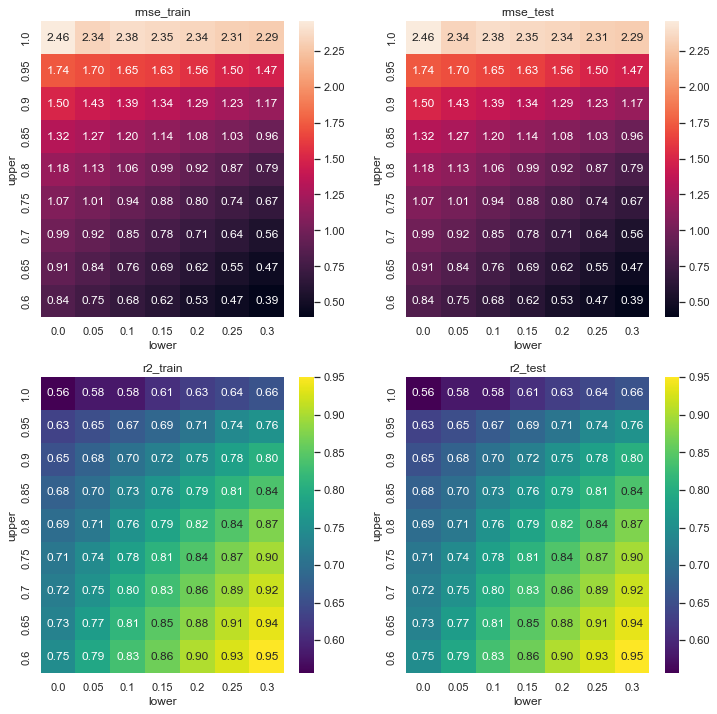

In [81]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
sns.heatmap(ax=ax[0, 0], data = size_effect[['upper', 'lower', 'rmse_train']].pivot('upper', 'lower', 'rmse_train'), annot=True, fmt=".2f")
ax[0, 0].set_title('rmse_train')
ax[0, 0].invert_yaxis()
sns.heatmap(ax=ax[0, 1], data = size_effect[['upper', 'lower', 'rmse_test']].pivot('upper', 'lower', 'rmse_test'), annot=True, fmt=".2f")
ax[0, 1].set_title('rmse_test')
ax[0, 1].invert_yaxis()
sns.heatmap(ax=ax[1, 0], data = size_effect[['upper', 'lower', 'r2_train']].pivot('upper', 'lower', 'r2_train'), cmap="viridis", annot=True, fmt=".2f")
ax[1, 0].set_title('r2_train')
ax[1, 0].invert_yaxis()
sns.heatmap(ax=ax[1, 1], data = size_effect[['upper', 'lower', 'r2_test']].pivot('upper', 'lower', 'r2_test'), cmap="viridis", annot=True, fmt=".2f")
ax[1, 1].set_title('r2_test')
ax[1, 1].invert_yaxis();
